# Building a YOLOv3 Object Detector with Darknet in the Cloud! (GPU ENABLED)
This tutorial will help you build YOLOv3 easily in the cloud with GPU enabled so that you can run real-time object detections as well as train your very own custom object detector!

# Step 1: Enabling GPU within your notebook
You need to enable GPU acceleration within your Colab notebook so that your YOLOv3 system will be able to process detections over 100 faster than CPU.

### Steps:

### i) Click **Edit** at top left of your notebook
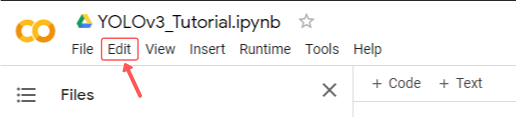
### ii) Click **Notebook Settings** within dropdown
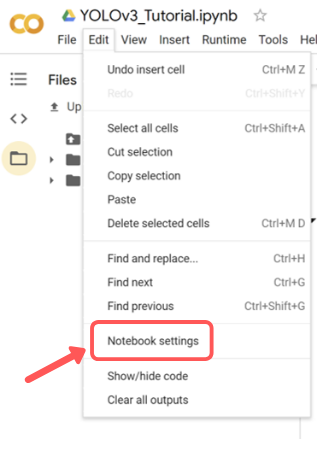
### iii) Under 'Hardware Accelerator' select **GPU** and then hit **Save**
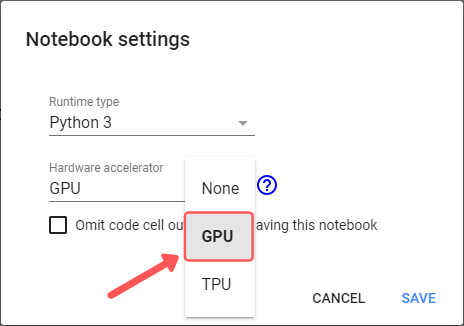

Your notebook should now have GPU enabled!

# Step 2: Cloning and Building Darknet
The following cells will clone darknet from AlexeyAB's famous repository, adjust the Makefile to enable OPENCV and GPU for darknet and then build darknet.

Do not worry about any warnings when you run the '!make' cell!

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

In [ ]:
# make darknet (build)
!make

# Step 3: Download pretrained YOLOv3 weights
YOLOv3 has been trained already on the coco dataset which has 80 classes that it can predict. We will grab these pretrained weights so that we can run YOLOv3 on these pretrained classes and get detections.

In [ ]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

### Mount  Google Drive


In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

# Training a Custom YOLOv3 Object Detector in the Cloud!
This requires a couple tricks and tips so make sure to follow along closely with the rest of the tutorial.

Create a folder in Google drive named Yolov3 and place these files there

In order to create a custom YOLOv3 detector we will need the following:

*   Labeled Custom Dataset in zipped format 
*   Custom .cfg file 
*   obj.data and obj.names files
*   train.txt file (test.txt is optional here as well)


# Step 2: Moving Your Custom Dataset Into Your Cloud VM


In [ ]:
# this is where my zip is stored (I created a yolov3 folder where I will get my required files from)
!ls /mydrive/yolov3

In [ ]:
# copy the .zip file into the root directory of cloud VM
!cp /mydrive/yolov3/obj.zip ../

In [ ]:
# unzip the zip file and its contents should now be in /darknet/data/obj
!unzip ../obj.zip -d data/

# Step 3: Configuring Files for Training
This step involves properly configuring your custom .cfg file, obj.data, obj.names and train.txt file.


## i) Cfg File
Copy over the yolov3.cfg to edit by running the cell below.

In [ ]:
# download cfg to google drive and change its name
!cp cfg/yolov3.cfg /mydrive/yolov3/yolov3_custom.cfg

## Now go to your google drive in yolov3 you will find a yolov3_custom.cfg file

### 1.You will need to change a few things

### 2.Open the .cjg in text editor mode

### 3.Comment out 2 line under #testing

### 4.Uncomment #batch=64 and #subdivision=16 you will in future comment these for when you are using detector

### 5.Set the max_batch size to - no of classes * 2000

### 6.Change the steps to =80 % of max_batches, 90 % of max_batch

### 7.Press crtl+f search yolo in yolo layer change the classes to the no of classes you have

### 8.Above yolo layer fing convolutional layer change the filter to = (no. of classes+5) * 3 repeate the process for all yolo layer



In [1]:
# upload the custom .cfg back to cloud VM from Google Drive
!cp /mydrive/yolov3/yolov3_custom.cfg ./cfg


'cp' is not recognized as an internal or external command,
operable program or batch file.


## ii) obj.names and obj.data 
Create a new file within a code or text editor called **obj.names** and you will make this file exactly the same as your classes.txt in the dataset generation step.

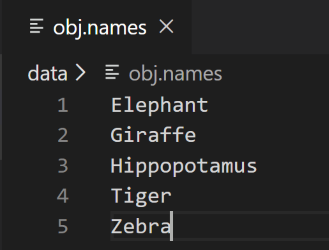

You will also create a **obj.data** file and fill it in like this (change your number of classes accordingly, as well as your backup location)

This backup path is where we will save the weights to of our model throughout training. Create a backup folder in your google drive and put its correct path in this file.

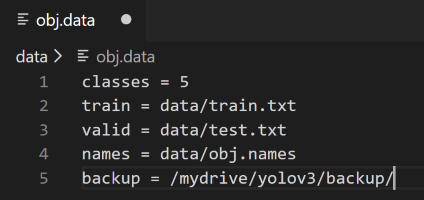



In [ ]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /mydrive/yolov3/obj.names ./data
!cp /mydrive/yolov3/obj.data  ./data


## iii) Generating train.txt
The last configuration file needed before we can begin to train our custom detector is the train.txt file which hold the relative paths to all our training images.

Luckily I have created a script that I showed in a past video that generates train.txt for us.

The script can be accessed from this [Github Repo](https://github.com/theAIGuysCode/YoloGenerateTrainingFile/blob/master/generate_train.py/)

Just download the file to your local machine or Google drive so we can upload it to your cloud VM.

In [ ]:
# upload the generate_train.py script to cloud VM from Google Drive
!cp /mydrive/yolov3/generate_train.py ./


Now we simply run the python script to do all the work for us.

In [ ]:
!python generate_train.py

In [ ]:
# verify train.txt can be seen in our darknet/data folder
!ls data/

# Step 4: Download pre-trained weights for the convolutional layers.
This step downloads the weights for the convolutional layers of the YOLOv3 network. By using these weights it helps your custom object detector to be way more accurate and not have to train as long. You don't have to use these weights but trust me it will help your modle converge and be accurate way faster. USE IT!

In [ ]:
# upload pretrained convolutional layer weights
!wget http://pjreddie.com/media/files/darknet53.conv.74

In [ ]:
# train your custom detector
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show

You can observe a chart of how your model did throughout the training process by running the below command. It shows a chart of your average loss vs. iterations. For your model to be 'accurate' you would aim for a loss under 2.

In [ ]:
imShow('chart.png')

**TRICK**: If for some reason you get an error or your Colab goes idle during training, you have not lost your weights! Every 100 iterations a weights file called **yolov3_custom_last.weights** is saved to **mydrive/yolov3/backup/** folder (wherever your backup folder is). This is why we created this folder in our Google drive and not on the cloud VM. If your runtime crashes and your backup folder was in your cloud VM you would lose your weights and your training progress.

We can kick off training from our last saved weights file so that we don't have to restart! Just run the following command but with your backup location.
```
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show
```

In [ ]:
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show

# Step 6: Run Your Custom Object Detector!!!
You have done it! You now have a custom object detector to make your very own detections. Time to test it out and have some fun!

In [ ]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3_custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom.cfg
%cd ..


In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights /mydrive/images/safari.jpg -thresh 0.3
imShow('predictions.jpg')